<a href="https://colab.research.google.com/github/lewis-m/erk-kinetics-tda/blob/master/KernelEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Prerequesite installations
#Run once everytime runtime is restarted

import numpy as np
import cython

!pip install pystan
!pip install dionysus

import pystan as ps

In [0]:
import scipy as sp
from scipy.integrate import tplquad
import math


class f_estimate:
  
  X = None
  r = 0
  kernel = None
  
  C_k = 1
  n = 0
  d = 0
  
  def __init__(self, X, r, kernel):
    self.X = X
    self.r = r
    self.kernel = kernel
    
    #self.C_k = tplquad(lambda x,y,z: kernel(x,y,z), -1,1,-1,1,-1,1)[0]
        
    self.n = len(X)
    self.d = len(X[0])
    
    
    
  
  def evaluate(self, x):
    sum = 0
    
    for xprime in self.X:
      y = (x - xprime)/math.sqrt(self.r)
      sum += self.kernel(*y)
            
    return sum/(self.n*self.C_k*math.sqrt(self.r*math.sqrt(self.d)))
    
    
  

In [0]:
#Upload file/data
from google.colab import files
import pandas as pd

uploaded = files.upload()

In [0]:
#Import empirical data
import numpy as np
import pandas as pd

xlsx = pd.ExcelFile('FirstData.xlsx')
df = pd.read_excel(xlsx, 'Wild Type')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

wild_type = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])

df = pd.read_excel(xlsx, 'Y130C')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

y130c = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])

df = pd.read_excel(xlsx, 'F53S')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

f53s = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])

df = pd.read_excel(xlsx, 'E203K')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

e203k = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])


#put all data into one data frame
bayes_td = np.array([wild_type, y130c, f53s, e203k])

In [0]:
def stan_model_yd(yeast_data, alt_ts = False):

  time_stamps = [0.5, 2, 3.25, 3.75, 5, 10, 20]
  
  if alt_ts:
    time_stamps = [0.5, 2, 3.25, 5, 10, 20, 40]

  yeast_code = """
  data {
      int<lower=0> T; // number of trials
      int<lower=0> TS; // number of timesteps
      vector[TS] ts; // time values
      real S0[TS,T]; // param S0
      real S1[TS,T]; // param S1
      real S2[TS,T]; // param S2
  }
  parameters {
      real P1;
      real P2;
      real Pi;
      real sigma1;
      //real sigma2;
      //real sigma3;
  }

  model {
      P1 ~ uniform(0,10);
      P2 ~ uniform(0,10);
      Pi ~ uniform(0,10);
      
      sigma1 ~ uniform(0,10);
      //sigma2 ~ uniform(0,10);
      //sigma3 ~ uniform(0,10);   

      for(i in 1:TS){
        real s0 = exp(-P1*ts[i]);
        real s1 = P1*(1-Pi)/(P1-P2)*(exp(-P2*ts[i]) - exp(-P1*ts[i]));
        real s2 = P1*Pi/(P1-P2)*(exp(-P2*ts[i]) - exp(-P1*ts[i])) + P2/(P1-P2)*(exp(-P1*ts[i]) - 1) + P1/(P1-P2)*(1-exp(-P2*ts[i]));
        
        S0[i, :] ~ normal(s0, sigma1);
        S1[i, :] ~ normal(s1, sigma1);
        S2[i, :] ~ normal(s2, sigma1);
      }
  }
  """

  S0 = np.stack([yeast_data[:, 0, 0], yeast_data[:, 1, 0], yeast_data[:, 2, 0], yeast_data[:, 3, 0], yeast_data[:, 4, 0], yeast_data[:, 5, 0], yeast_data[:, 6, 0]])
  S1 = np.stack([yeast_data[:, 0, 1], yeast_data[:, 1, 1], yeast_data[:, 2, 1], yeast_data[:, 3, 1], yeast_data[:, 4, 1], yeast_data[:, 5, 1], yeast_data[:, 6, 1]])
  S2 = np.stack([yeast_data[:, 0, 2], yeast_data[:, 1, 2], yeast_data[:, 2, 2], yeast_data[:, 3, 2], yeast_data[:, 4, 2], yeast_data[:, 5, 2], yeast_data[:, 6, 2]])

  S0 = np.array(S0, dtype = float)
  S1 = np.array(S1, dtype = float)
  S2 = np.array(S2, dtype = float)

  S0 = S0/5
  S1 = S1/5
  S2 = S2/5
  
  dimensions = yeast_data.shape

  yeast_dat = {'T': dimensions[0],
               'TS': dimensions[1],
               'ts': time_stamps,
               'S0': S0,
               'S1': S1,
               'S2': S2}

  sm = ps.StanModel(model_code=yeast_code)
  fit = sm.sampling(data=yeast_dat, iter=1000, chains=4)
  
  return fit

WildType
[0.0066969  0.00798622 0.01464332]
Rips done
{0: array(1704.53985526), 1: array(1789.60773647), 2: array(832.09417512), 3: array(442.42392473), 4: array(1330.71683953), 5: array(1573.77169565), 6: array(51.64322188), 7: array(160.96111457), 8: array(1839.24355991), 9: array(1180.94164635), 10: array(1887.8672484), 11: array(70.20887034), 12: array(186.18652037), 13: array(654.07557413), 14: array(1616.74639286), 15: array(256.56469888), 16: array(2304.58721061), 17: array(567.53025545), 18: array(138.07679262), 19: array(713.32382874), 20: array(1388.08727944), 21: array(1754.86047506), 22: array(2006.22516668), 23: array(41.73790503), 24: array(958.72131218), 25: array(1249.62727824), 26: array(287.34816545), 27: array(81.43761037), 28: array(163.54547035), 29: array(1130.36321784), 30: array(924.32639404), 31: array(787.16687968), 32: array(1122.10191082), 33: array(632.84248642), 34: array(1164.05978568), 35: array(1893.93306722), 36: array(474.2998886), 37: array(68.869310

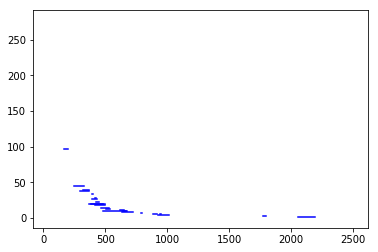

Diagram with 225 points


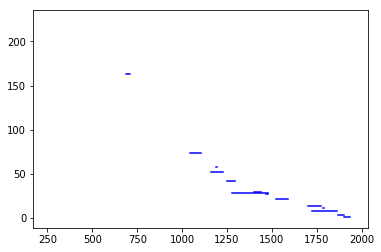

Diagram with 9135 points


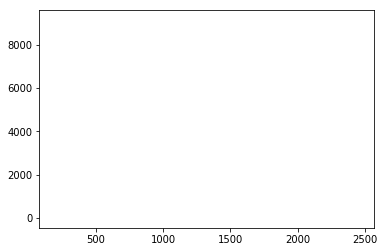

Y130C
[0.00670839 0.00342517 0.0085232 ]
Rips done
{0: array(4939.66754702), 1: array(3132.2444799), 2: array(5956.87442008), 3: array(4632.52734047), 4: array(1455.88402164), 5: array(8206.06776986), 6: array(9219.29646911), 7: array(583.57390276), 8: array(2844.91173335), 9: array(1005.02634928), 10: array(419.98899712), 11: array(3457.87422074), 12: array(1405.45224362), 13: array(4505.98312467), 14: array(7836.73852589), 15: array(1222.7244359), 16: array(7826.42791222), 17: array(1571.7911109), 18: array(6939.30015516), 19: array(3766.87745396), 20: array(1060.96299407), 21: array(1653.70933817), 22: array(5908.3132501), 23: array(1967.59108246), 24: array(5868.61993986), 25: array(5456.45306871), 26: array(1061.78503062), 27: array(3800.0265392), 28: array(3203.1438614), 29: array(6558.82383777), 30: array(9284.20284734), 31: array(250.07785364), 32: array(4429.37932963), 33: array(5741.20797752), 34: array(1803.73201282), 35: array(9140.52428339), 36: array(4878.58961257), 37: a

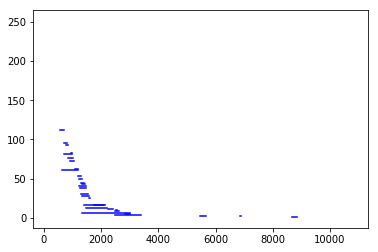

Diagram with 206 points


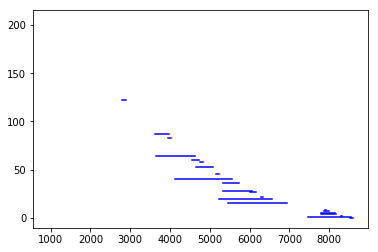

Diagram with 12884 points


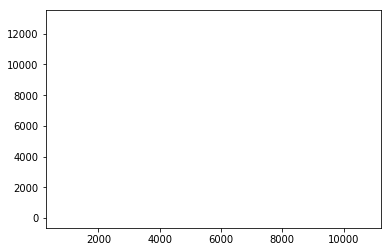

F53S
[0.00958408 0.00598746 0.01223889]
Rips done
{0: array(2092.38787914), 1: array(1224.98168252), 2: array(2310.03178103), 3: array(1505.34203419), 4: array(3209.13859922), 5: array(525.74669505), 6: array(1363.65659754), 7: array(2172.35991587), 8: array(1981.35502913), 9: array(364.87051097), 10: array(3503.2781213), 11: array(1385.63477815), 12: array(1946.79860893), 13: array(2322.33687912), 14: array(521.30616969), 15: array(2623.67694632), 16: array(3466.83847609), 17: array(92.70750003), 18: array(3549.65259853), 19: array(1069.56962387), 20: array(759.35009832), 21: array(2876.20065811), 22: array(1552.88973986), 23: array(1835.26744754), 24: array(1390.83647716), 25: array(2059.688585), 26: array(2760.26266974), 27: array(1308.46405299), 28: array(1402.61401334), 29: array(1328.66667336), 30: array(1619.01126165), 31: array(1856.53393725), 32: array(2825.15569205), 33: array(2714.99948679), 34: array(552.77572715), 35: array(1885.62862317), 36: array(353.54265954), 37: arra

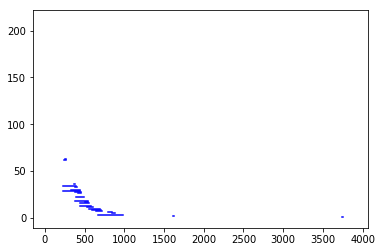

Diagram with 170 points


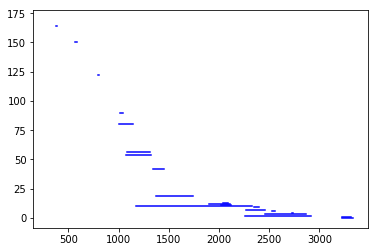

Diagram with 23493 points


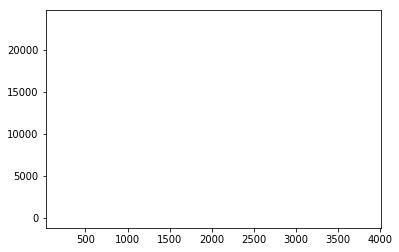

E203K
[0.01968807 0.00520722 0.00951728]
Rips done
{0: array(104.90036265), 1: array(935.51409362), 2: array(1125.70798469), 3: array(1704.99340566), 4: array(192.19465114), 5: array(881.31661617), 6: array(2304.81069623), 7: array(196.20604322), 8: array(451.520112), 9: array(509.68863966), 10: array(160.8350365), 11: array(925.02261649), 12: array(384.13470412), 13: array(44.28908685), 14: array(43.56722373), 15: array(774.28584761), 16: array(423.34575447), 17: array(54.00229789), 18: array(651.93229867), 19: array(69.66167011), 20: array(107.8232648), 21: array(793.1278405), 22: array(1863.42641278), 23: array(2086.00925308), 24: array(1719.60000536), 25: array(1560.66897543), 26: array(1198.42413349), 27: array(527.82753915), 28: array(745.70549849), 29: array(1237.84367639), 30: array(1635.45618525), 31: array(179.28453956), 32: array(591.95120957), 33: array(1905.17317747), 34: array(1166.52392294), 35: array(1262.67379591), 36: array(212.22765001), 37: array(877.70668556), 38: 

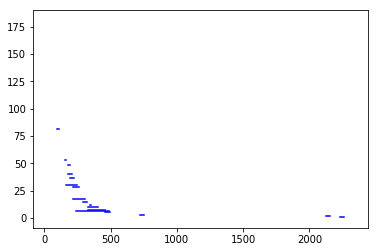

Diagram with 145 points


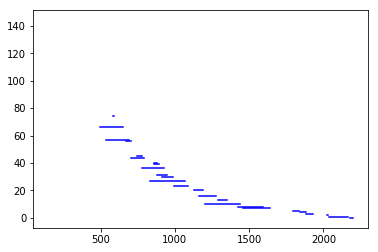

Diagram with 31738 points


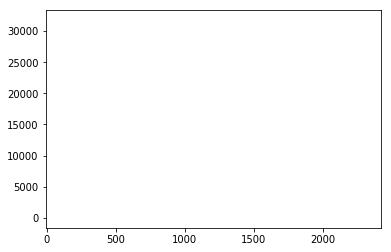

inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf


In [0]:
import dionysus as d
import numpy as np
from numpy import linalg
from scipy.stats import multivariate_normal, gaussian_kde
import math
import statistics
from statsmodels.nonparametric.kernel_density import KDEMultivariate


def build_filtration(X, r, kernel):
  #est = f_estimate(X, r, kernel)
  est = KDEMultivariate(data=[np.array(X[:,0]),
                              np.array(X[:,1]),
                              np.array(X[:,2])],
                              bw='cv_ml',
                              var_type='ccc')
  print(est.bw)
  
  filt = d.fill_rips(X, 2, statistics.mean(est.bw))
    
  data_points = {}
  
  for i in range(len(X)):
    data_points.update({i : est.pdf(X[i])})
  
  print(data_points)
    
  for simplex in filt:
    min_val = 1000000
    for vertex in simplex:
      #print(data_points[vertex])
      new_val = data_points[vertex]
      
      if new_val < min_val:
        min_val = new_val
    
    simplex.data = min_val
      
  filt.sort(reverse = True)
  
  
  return filt


def gaussian_kernel(x, y ,z):
  input_x = [x, y, z]
  return multivariate_normal.pdf(input_x, mean=[0,0,0], cov=[[1,0,0],[0,1,0],[0,0,1]])

def triangular_kernel(x, y, z):
  input_x = [x, y, z]
  norm = linalg.norm(input_x, 2)
  
  if norm/(math.sqrt(math.pi/3)) > 1:
    return 0
  else:
    return 1 - norm/((math.pi/3)**(1./3))

  

y_type = ['WildType', 'Y130C', 'F53S', 'E203K']

"""
total_bayes_data = []

for i in range(len(y_type)):
  fit = stan_model_yd(bayes_td[i])
  
  print('\n Bayesian model for yeast type %r:' % y_type[i])
  print(fit)

  posterior = fit.extract()
  bayes_data = np.stack([posterior['P1'], posterior['P2'], posterior['Pi']])
  bayes_data = np.swapaxes(bayes_data, 0, 1)
  total_bayes_data.append(bayes_data)
"""
  
all_dgms_0 = []
all_dgms_1 = []
all_dgms_2 = []


for i in range(len(y_type)):
  print(y_type[i])
  filt = build_filtration(total_bayes_data[i], 0.005, gaussian_kernel)
  #filt2 = build_filtration(total_bayes_data[i], 0.005, gaussian_kernel)
  #filt3 = build_filtration(total_bayes_data[i], 0.001, gaussian_kernel)

  hom = d.homology_persistence(filt)
  
  dgms = d.init_diagrams(hom, filt)
  
  all_dgms_0.append(dgms[0])
  all_dgms_1.append(dgms[1])
  all_dgms_2.append(dgms[2])

  d.plot.plot_bars(dgms[0], show = True)
  
  print(dgms[1])
  d.plot.plot_bars(dgms[1], show = True)
  
  print(dgms[2])
  d.plot.plot_bars(dgms[2], show = True)


for i in range(3):
  for j in range(i + 1, 4):
    print(d.bottleneck_distance(all_dgms_0[i], all_dgms_0[j]))
    print(d.bottleneck_distance(all_dgms_1[i], all_dgms_1[j]))
    print(d.bottleneck_distance(all_dgms_2[i], all_dgms_2[j]))

KeyboardInterrupt: ignored

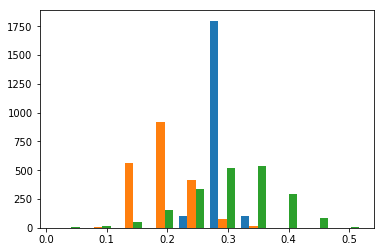

In [0]:
import numpy as np
from numpy import linalg
from scipy.stats import multivariate_normal, gaussian_kde
from scipy.integrate import dblquad
import math
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import matplotlib.pyplot as plt


est0 = KDEMultivariate(data=[np.array(total_bayes_data[0][:,0]),np.array(total_bayes_data[0][:,1]),np.array(total_bayes_data[0][:,2])], var_type='ccc')



x_range = np.arange(0., 0.5, 0.001)

plt.hist(total_bayes_data[0])
y_range = [dblquad(lambda y,z: est0.pdf([x, y, z]),-1,1,-1,1)[0] for x in x_range]
plt.plot(x_range, y_range)
plt.show()


plt.hist(total_bayes_data[1])
plt.show()


plt.hist(total_bayes_data[2])
plt.show()

In [0]:
[np.array(total_bayes_data[0][:,0]),np.array(total_bayes_data[0][:,1]),np.array(total_bayes_data[0][:,2])]

[array([0.30104574, 0.29260228, 0.2901027 , ..., 0.29001983, 0.28854521,
        0.26995528]),
 array([0.16066734, 0.18062512, 0.23592781, ..., 0.12537684, 0.17044343,
        0.20511583]),
 array([0.27425132, 0.36286862, 0.16884023, ..., 0.41022495, 0.31866812,
        0.3195372 ])]